In [1]:
import sys
import os
import subprocess
import glob
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from optparse import OptionParser
from PIL import Image#, ImageTk
from subprocess import Popen, PIPE
import matplotlib.patches as patches
import scipy.misc as scimisc
import scipy.ndimage

## Visualizing an example image

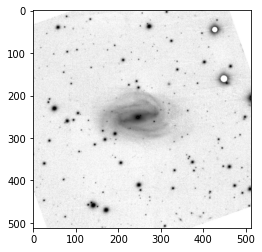

In [2]:
img = Image.open('../galaxies/pgc2_d25x2_rot_r.png')

# img_rot = scipy.ndimage.rotate(img, -90)

plt.imshow(img)

In [3]:
img_rot = scipy.ndimage.rotate(img, -45)

np.mean(np.asarray(img_rot), axis=2).shape

(724, 724)

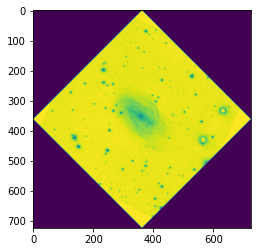

In [4]:
plt.imshow(np.mean(np.asarray(img_rot), axis=2))

In [5]:
img_tmp = np.asarray(img_rot)
img_rot = np.zeros((128, 128, 3))
img_tmp.shape



(724, 724, 2)

## Auxiliary function
To average the parameters measured by users based on their performance.
    "n" is the weight number assgined to invidiaul users, when averaging their results. 

In [6]:
def p_append(params, email, p):
    
    n = 0
    
    ### professionals
    if email=='rbtully1@gmail.com': n = 4
    elif email=='rtully@hawaii.edu': n = 4
    elif email=='ekourkchi@gmail.com': n = 3
    elif email=='s.eftekharzadeh@gmail.com': n=3
    elif email=='mokelkea@hawaii.edu': n = 3
    elif email=='chasemu@hawaii.edu': n = 3
    elif email=='jrl2014@hawaii.edu': n=2
    elif email=='dschoen@hawaii.edu': n = 3
    elif email=='adholtha@hawaii.edu': n = 4
    elif email=='chuangj@hawaii.edu': n = 2
    elif email=='mi24@hawaii.edu': n = 3
    elif email=='mka7@hawaii.edu': n = 2
    elif email=='a.danesh61@gmail.com': n = 2
    
    ### amateurs
    elif email=='cgrubner0@gmail.com': n = 1
    elif email=='pascal.jouve@free.fr': n = 2
    elif email=='dlsaintsorny@gmail.com': n = 2
    elif email=='arnaud.ohet@gmail.com': n = 1
    elif email=='hawaii@udrea.fr': n = 2
    elif email=='helenecourtois33@gmail.com': n = 2
    elif email=='claude.rene21@gmail.com': n = 1
    elif email=='fredwallet@gmail.com': n = 1
    elif email=='henri140860@wanadoo.fr': n = 1
    elif email=='joannin.lycee@free.fr': n = 2
    elif email=='bevig434@gmail.com': n = 1
    elif email=='pierrefcevey@gmail.com': n = 1
    elif email=='pierre@macweber.ch': n = 1
    elif email=='arnaudoech@gmail.com': n = 1
    elif email=='lionmarm@gmail.com': n = 1
    elif email=='neilljd@gmail.com': n = 3
    elif email=='mseibert@carnegiescience.edu': n = 3
        
    for i in range(n): params.append(p)
        
    return params  

def median_param(param_list, param_email):
    
    p_lst = []
    N = len(param_list)
    for i in range(N):
        p_lst = p_append(p_lst, param_email[i], param_list[i])
    return np.median(p_lst)
    
    

## Importing the Output of the Galaxy Inclination Zoo interface
    "inc" is the the average of the evaluated inclinations by users
    "dPA" is the correction angle to align the semi-major axis of the galaxy horizontally
    "zoom" is the image scale chosen by users to work on the image

In [7]:
inFile = 'EDD_distance_cf4_v27.csv'
table  = np.genfromtxt(inFile , delimiter='|', filling_values=-1, names=True, dtype=None, encoding=None)
pgc  = table['pgc']
inc  = table['inc']
face_on  = table['fon']
inc_note = table['inc_note']
inc_flg = table['inc_flg']

inFile = 'std_scales.csv'
table  = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None, encoding=None)
pgc_std  = table['pgcID']
dPA_std  = table['dPA']
zoom_std  = table['zoom']

inFile = 'users_scales.csv'
table  = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None, encoding=None)
pgc_user  = table['pgcID']
dPA_user  = table['dPA']
zoom_user  = table['zoom']
email_user  = [' '.join(dummy.split()) for dummy in table['email']]


In [14]:
######################################
## This function allows to execute the OS commands
def xcmd(cmd,verbose):

    if verbose: print('\n'+cmd)

    tmp=os.popen(cmd)
    output=''
    for x in tmp: output+=x
    if 'abort' in output:
        failure=True
    else:
        failure=tmp.close()
    if False:
        print('execution of %s failed' % cmd)
        print('error is as follows', output)
        sys.exit()
    else:
        return output

######################################
# Rotating and zoomming based of the user inputs
def convertIMAGE(im_root, pgcID, angle=0., scale=1., size=128, suffix=None):
    
    if scale<1.:
        scale=1

    img = Image.open(im_root + 'pgc'+str(pgcID)+'_d25x2_rot_i.png')
    
    # image rotation
    img_rot = scipy.ndimage.rotate(img, -angle)
    
    img_rot = np.asarray(img_rot)
    
    N = img_rot.shape[0]

    # image scaling
    
    d = N
    p =  int(d/scale)
    d1 = int(np.round(d/2-p/2))
    d2 = int(np.round(d1 + p))
    
    
    try:
        img_rot = np.mean(img_rot, axis=2)
        img_rot = img_rot.astype(np.uint8)
    except:
        pass
       
    
    img_cut = img_rot[d1:d2, d1:d2]
    
    img = Image.fromarray(img_cut, 'L').resize((size,size))

    outDIR = './' + str(size)+'x'+str(size) + '_i'
    if not os.path.exists(outDIR):
        xcmd('mkdir '+outDIR, True)
    
    if not suffix is None:
        outName = outDIR+'/pgc'+str(pgcID)+'_'+str(size)+'x'+str(size)+'_'+suffix+'.i.jpg'
    else:
        outName = outDIR+'/pgc'+str(pgcID)+'_'+str(size)+'x'+str(size)+'.i.jpg'

    img.save(outName, "JPEG")
    
    return img_cut

In [15]:
im_root = '../galaxies/'
for j, id in enumerate(pgc):
    
    im_path =  im_root+'pgc'+str(id)+'_d25x2_rot_i.png'
    
    available = os.path.exists(im_path)
    
    ## 'F' stands for face-on
    ## '0' spirals with inclinations less than 45 deg from face-on
    ## '45'-'90' spirals with inclinations between 45 and 90 deg
    fon = " ".join(face_on[j].split())
    if ((fon == 'F' and inc_flg[j]>0) or (inc_flg[j]>0 and 'face_on' in inc_note[j])):
        suffix = 'F'
    elif inc_flg[j]>0:
        suffix = '0'
    else:
        suffix = "%d"%inc[j]
    
    
    if available:
        
        dPA = 0
        zoom = 1.0
        if id in pgc_std:
            ix,  = np.where(pgc_std==id)
            dPA  = dPA_std[ix][0]
            zoom = zoom_std[ix][0]
        elif id in pgc_user:
            ix,  = np.where(pgc_user==id)
            emails = [email_user[i] for i in ix]
            dPA  = median_param(dPA_user[ix], emails)
            zoom = median_param(zoom_user[ix],emails)
        try: 
            img = convertIMAGE(im_root, id, angle=dPA, scale=zoom*0.7, size=128, suffix=suffix)
        except:
            print('Problem: ' + im_path)


mkdir ./128x128_i


In [7]:
str(np.iinfo(img.dtype).dtype) == 'unit8'

False

In [8]:
## labeling inclinations with numerical numbers
def inc_class(inc):
    
    if inc=='0':
        return 0
    elif inc=='F':
        return 1
    else:
        return int(inc)

## Bundling all images and their inclination labels
In order to increase the sampe size, we flip each image horzionatlly and vertically.
The inclination labels of the flipped images are the same as the original image

In [19]:
files = glob.glob('128x128_g/*jpg')
# N = 4*len(files)
N = len(files)

images = np.zeros((N, 128, 128, 3), dtype=np.dtype('>i4'))

# firs index for pgcID -> labels[0][..]
# second index for the inclination class -> labels[1][..]
labels = np.zeros((2, N), dtype=np.dtype('>i4'))

for i, fname in enumerate(files):
    pgcID =  int(fname.split("/")[1].split('_')[0][3:])
    
    try:
        inc   =  fname.split("_")[3].split('.')[0]
    except:
        print(fname)
        sys.exit()  
        
    
    tmp = np.asarray(Image.open(fname))
    
    img = np.zeros((128, 128, 3), dtype=np.dtype('>i4'))
    img[:,:,0] = tmp
    img[:,:,1] = tmp
    img[:,:,2] = tmp
    
    images[i] = img
    clss = inc_class(inc)
    labels[1][i] = clss
    labels[0][i]   = pgcID
    
#     images[4*i] = img
#     ## Flipping the image
#     images[4*i+1] = np.flip(img, axis=0)
#     images[4*i+2] = np.flip(img, axis=1)
#     images[4*i+3] = np.flip(np.flip(img, axis=0),axis=1)
    
#     clss = inc_class(inc)  # using the numerical inclination classes
#     labels[1][4*i] = clss
#     labels[1][4*i+1] = clss
#     labels[1][4*i+2] = clss
#     labels[1][4*i+3] = clss
    
#     labels[0][4*i]   = pgcID
#     labels[0][4*i+1] = pgcID
#     labels[0][4*i+2] = pgcID
#     labels[0][4*i+3] = pgcID    

## Displaying an example image and its associated labels

PGC:  5059723
INC:  0


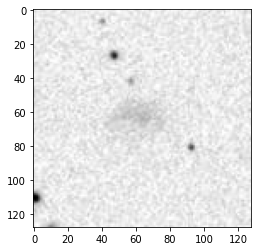

In [20]:
i = 748
print("PGC: ", labels[0][i])
print("INC: ", labels[1][i])
plt.imshow(images[i])

## Saving the array of images

In [21]:
np.savez_compressed('data_128x128_g_originals.npz', images=images, labels=labels)  

## Recovering the array  of images
To test if everything is saved and recoverred properly

In [10]:
data = np.load('data_128x128_g.npz')
images_out = data['images']
labels_out = data['labels'] 
data.close() 

## Using the same index to display the recovered image

PGC:  3529177
INC:  72


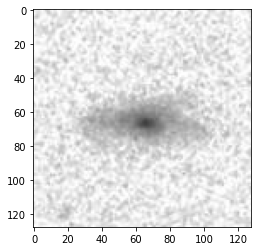

In [12]:
i = 748
print("PGC: ", labels[0][i])
print("INC: ", labels[1][i])
plt.imshow(images[i])

## This is the original 512x512 image

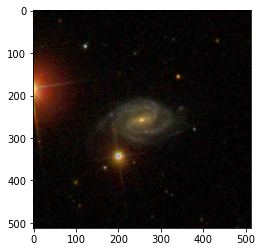

In [25]:
img = Image.open('./galaxies/pgc50351_d25x2_rot_gri.sdss.jpg')

plt.imshow(img)